## Machine learning on Social Netowrk Graphs

In [1]:
import os
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
import seaborn as sns

default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

In this chapter we will focus on using the techniques outlined in previous chapters to analyze the most-common example of nowadays graphs: Social Networks. In particular we will apply the techniques outlined in previous chapters to investigate the topological properties of the networks, such as 
1. identifying relevant communities as well as 
2. identifying particularly important nodes in the network. 

We will then use node embeddings to leverage on the power of topological information for different tasks, such as link prediction (as a potential recommendation engine for new friends) 

#### Dowload the dataset

First, we need to download the dataset. We will be using the [SNAP Facebook social graph](http://snap.stanford.edu). The dataset was created by collection Facebook user information from survey participants.  More in detail, 10 ego-networks were created from ten users. Each user was asked to identify all the circles (list of friends) to which their friends belong. Then, all the "ego-network" were combined in a single graph.

In [2]:
#!wget http://snap.stanford.edu/data/facebook_combined.txt.gz
#!wget http://snap.stanford.edu/data/facebook.tar.gz
#!gzip -d facebook_combined.txt.gz
#!tar -xf facebook.tar.gz

### Overview of the Dataset

The code above downloads two main files:
*   a text file containing the edge list of the graph. The graph is actually created
*   an archive containing a folder ("facebook") with all the information related to each ego-network



In [3]:
# check the downloaded content
!ls

01_Social_network_analysis.ipynb  facebook_combined.txt     facebook.tar.gz
facebook			  facebook_combined.txt.gz  facebook.tar.gz.1


In [4]:
# take a look at the first lines of the edge list
!head facebook_combined.txt

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10


We can now proceed loading the combined network using networkx. We will also load the nodeId of the 10 "ego-user"

In [5]:
G = nx.read_edgelist("facebook_combined.txt", create_using=nx.Graph(), nodetype=int)

In [6]:
print(f"Graph Order: {G.number_of_nodes()}")
print(f"Graph Size: {G.number_of_edges()}")

Graph Order: 4039
Graph Size: 88234


In [7]:
# Each file in the "facebook" directory is named as nodeId.format
# where nodeId is the id of an ego-user and format is the format of the file
ego_nodes = set([int(name.split('.')[0]) for name in os.listdir("facebook/")])
print(ego_nodes)

#better!
ego_nodes = set([int(p.stem) for p in Path("facebook").glob("*.circles")])
print(ego_nodes)

{0, 107, 3980, 3437, 686, 1684, 1912, 698, 348, 414}
{0, 107, 3980, 3437, 686, 1684, 1912, 698, 348, 414}


Let's visualize the network for a deeper understanding

In [8]:
#Create network layout for visualizations
spring_pos = nx.spring_layout(G)

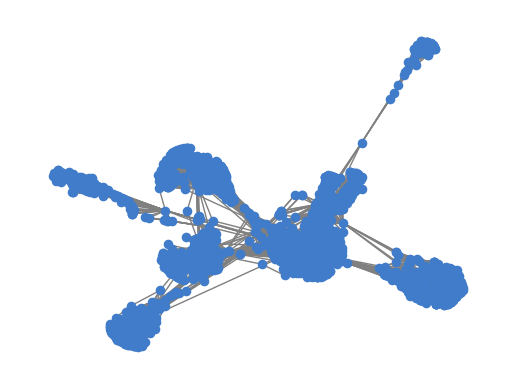

In [9]:
plt.axis("off")
nx.draw_networkx(G, pos=spring_pos, node_color=default_node_color, edge_color=default_edge_color, with_labels=False, node_size=35)

### Network Analysis

In [54]:
def draw_metric(G, dct, spring_pos, ego_nodes):
  """ draw the graph G using the layout spring_pos.
      The top 10 nodes w.r.t. values in the dictionary dct
      are enhanced in the visualization """
  top = 10
  max_nodes =  sorted(dct.items(), key = lambda v: -v[1])[:top]
  
  max_keys = [key for key,_ in max_nodes]
  max_vals = [val*300 for _, val in max_nodes]

  plt.axis("off")
  plt.title(f"Overlap with ego nodes: {len(set(max_keys).intersection(ego_nodes))} \n Ego nodes: {sorted(ego_nodes)} \n Metrics nodes: {sorted(max_keys)} ")
  
  nx.draw_networkx(G, 
                   pos=spring_pos, 
                   cmap='Blues', 
                   edge_color=default_edge_color,
                   node_color=default_node_color, 
                   node_size=3,
                   alpha=0.4, 
                   with_labels=False)
  
  nx.draw_networkx_nodes(G, 
                         pos=spring_pos, 
                         nodelist=max_keys, 
                         node_color=enhanced_edge_color,
                         node_size=max_vals)

In [43]:
# betweenness centrality
bC = nx.betweenness_centrality(G)
np.mean(list(bC.values()))

0.0006669573568730229

Min betweenness centerality: 0.0
Max betweenness centerality: 0.4805180785560152


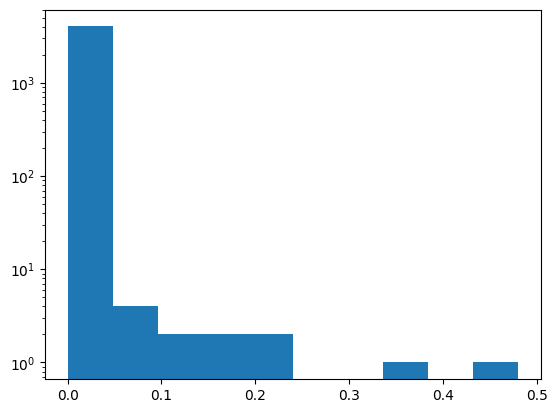

In [44]:
print(f"Min betweenness centerality: {np.array(list(bC.values())).min()}")
print(f"Max betweenness centerality: {np.array(list(bC.values())).max()}")

_ = plt.hist(list(bC.values()))
plt.yscale("log")

In a highly-clustered network, it's not a good idea to look at the average of betweenness centrlity. In this network, we have a few highly central nodes (perhaps the egos), and many many nodes with extremely low betweenness centrality. Now let's draw nodes with the highest betweenness centrality values from high to low (larger to smaller circles)

/home/saghar/Inmeta/Learn/GDS/Graph-Machine-Learning/.venv/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


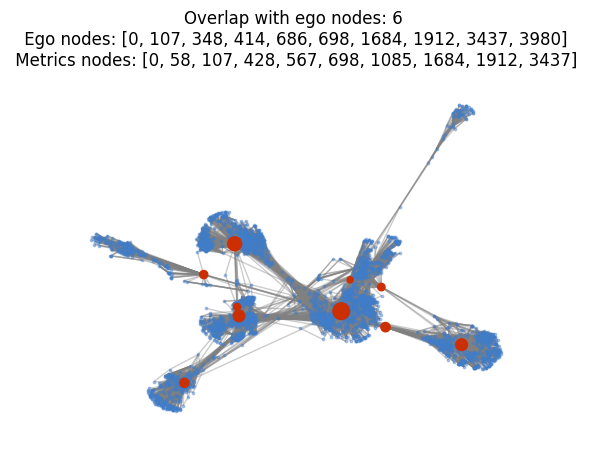

In [55]:
draw_metric(G,bC,spring_pos, ego_nodes)

In [34]:
# global efficiency
gE = nx.global_efficiency(G)
print(gE)

0.30657814798734856


In [35]:
# average clustering
aC = nx.average_clustering(G)
print(aC)

0.6055467186200876


In [36]:
# degree centrality
deg_C = nx.degree_centrality(G)
np.mean(list(deg_C.values()))

0.010819963503439287

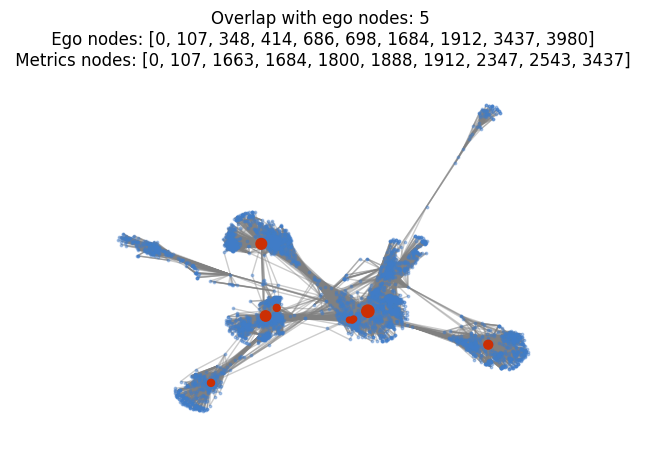

In [56]:
draw_metric(G,deg_C,spring_pos, ego_nodes)

In [38]:
# closeness centrality
clos_C = nx.closeness_centrality(G)
np.mean(list(clos_C.values()))

0.2761677635668376

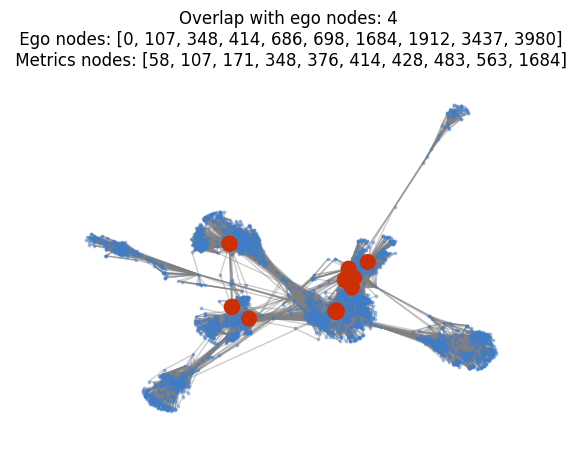

In [57]:
draw_metric(G,clos_C,spring_pos, ego_nodes)

In [40]:
# assortativity
assortativity = nx.degree_pearson_correlation_coefficient(G)
assortativity

0.06357722918564918

In [41]:
t = nx.transitivity(G)
t

0.5191742775433075

In [98]:
import networkx.algorithms.community as nx_comm
nx_comm.modularity(G, nx_comm.label_propagation_communities(G))

0.7368407345348218

#### Community detection
In the following cells we will automatically detect communities using infromation from the network topology

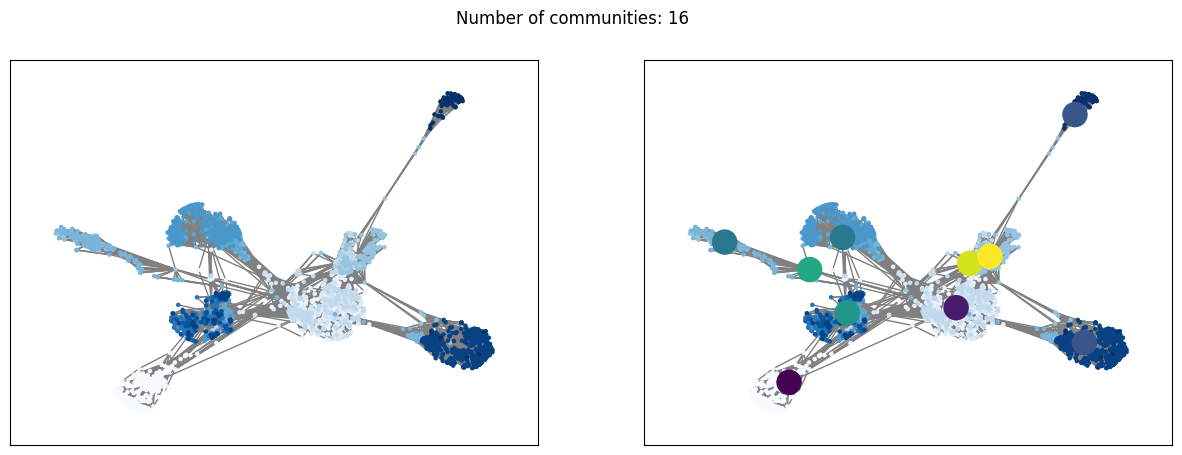

In [120]:
parts = nx_comm.louvain_communities(G)
  
values = dict()
values = []
ego_values = []

# Here we're assuming each node belongs only to ONE community, which is NOT a very good assumption!!
for i, part in enumerate(parts):
  for node in G.nodes():
    if node in part:
      values.append(i)
  for node in ego_nodes:
    if node in part:
      ego_values.append(i)
      
n_sizes = [5]*len(G.nodes())
#for node in ego_nodes:
#  n_sizes[node] = 250
  

fig, ax = plt.subplots(1,2, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.flatten()
#plt.axis("off")
plt.suptitle(f"Number of communities: {len(parts)}")
nx.draw_networkx(G, pos=spring_pos, cmap=plt.get_cmap("Blues"), 
                 edge_color=default_edge_color, node_color=values, 
                 node_size=n_sizes, with_labels=False, ax=ax[0])
nx.draw_networkx(G, pos=spring_pos, cmap=plt.get_cmap("Blues"), 
                 edge_color=default_edge_color, node_color=values, 
                 node_size=n_sizes, with_labels=False, ax=ax[1])

# enhance color and size of the ego-nodes
nodes = nx.draw_networkx_nodes(G,spring_pos,ego_nodes,node_color=ego_values, ax=ax[1])
#nodes.set_edgecolor(enhanced_node_color)

### FIXME!! 

Here we seem to have too much overlap. It will be nice to visualize individual communities and the ego node belonging to them.

some ego users seem to belong to the same community. perhaps they are actually friends on facebook and therefore the ego networks are partially overlapping. This goes against the assumption we made about completely disjoint communities.

### Ego-net analysis

Since the combined network we are analyzing is actually composed by 10 sub-networks (ego-networks), it's interesting to inspect all those subnetwork. In the following cells we will analyze the subnetwork of the ego-user "0".

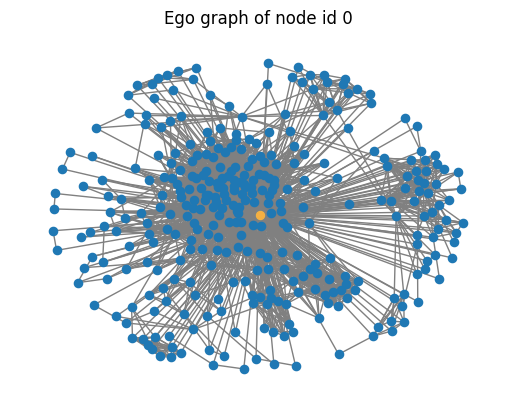

In [131]:
ego_node_id = 0
G_ego = nx.read_edgelist("facebook/0.edges", create_using=nx.Graph(), nodetype=int)

# The edge list file does't contain ego-alter edges but they're assumed in this type of graph, so we add them
for node in G_ego.copy():
  G_ego.add_edge(ego_node_id,node)

plt.axis("off")
plt.title(f"Ego graph of node id {ego_node_id}")
pos_G_ego = nx.spring_layout(G_ego)
nx.draw_networkx(G_ego, pos=pos_G_ego, with_labels=False, node_size=35, edge_color=default_edge_color)
nx.draw_networkx_nodes(G_ego ,pos_G_ego ,[ego_node_id], node_color=enhanced_node_color, node_size=35)

Nodes belonging to each subnetwork are stored in the "facebook" folder under the name nodeId.circles

In [ ]:
import pandas as pd
circles = {}

with open("facebook/0.circles") as f_in:
  line = f_in.readline().rstrip().split("\t")
  while line and not '' in line:
    circles[line[0]] = [int(v) for v in line[1:]]
    line = f_in.readline().rstrip().split("\t")

In [ ]:
node_colors = [0] * G0.number_of_nodes()
count = 0
for key in circles:
  circle = circles[key]
  for node in circle:
    if node < G0.number_of_nodes():
      node_colors[node] = count
  count += 1

nx.draw_networkx(G0, pos=pos_G0, with_labels=False, node_size=35, node_color=node_colors, edge_color=default_edge_color)

In [ ]:
parts = community.best_partition(G0)
values = [parts.get(node) for node in G0.nodes()]

plt.axis("off")
nx.draw_networkx(G0, pos=pos_G0, cmap=plt.get_cmap("Blues"), edge_color=default_edge_color, node_color=values, node_size=35, with_labels=False)

In [ ]:
# community found does not reflect the circles
set(parts.values())
len(circles)

In [ ]:
# a node can be present in more than one list??
for i in circles:
  for j in circles:
    if i != j:
      for n1 in circles[i]:
        for n2 in circles[j]:
          if n1 == n2:
            print(n1, 'present in ',i,'found in', j)
            assert(False)

In [ ]:
#@title  
nx.average_shortest_path_length(G0)
nx.global_efficiency(G0)
nx.average_clustering(G0)

np.mean(list(nx.betweenness_centrality(G0).values()))
np.mean(list(nx.closeness_centrality(G0).values()))
np.mean(list(nx.degree_centrality(G0).values()))
nx.degree_pearson_correlation_coefficient(G)
nx.transitivity(G)

import networkx.algorithms.community as nx_comm
nx_comm.modularity(G, nx_comm.label_propagation_communities(G))

### Embeddings for Supervised and Unsupervised Tasks 

We will now proceed with the actual machine learning task. In particular, we will perform an edge prediction task for the Facebook social graph.

#### parse node features

As first, let's load all the features describing each node. This is not a straightforward process and requires a bit of codes, since each subnetwork contains it's own set of features, whose names and values are stored in different files. 

In [ ]:
# Adapted from https://github.com/jcatw/snap-facebook

feat_file_name = "feature_map.txt"
feature_index = {}  #numeric index to name
inverted_feature_index = {} #name to numeric index
network = nx.Graph()

def parse_featname_line(line):
  """ used to parse each line of the files containing feature names """
  line = line[(line.find(' '))+1:]  # chop first field
  split = line.split(';')
  name = ';'.join(split[:-1]) # feature name
  index = int(split[-1].split(" ")[-1]) #feature index
  return index, name

def load_features():
  """ 
  parse each ego-network and creates two dictionaries:
      - feature_index: maps numeric indices to names
      - inverted_feature_index: maps names to numeric indices
  """
  import glob
  feat_file_name = 'tmp.txt'
  # may need to build the index first
  if not os.path.exists(feat_file_name):
      feat_index = {}
      # build the index from data/*.featnames files
      featname_files = glob.iglob("facebook/*.featnames")
      for featname_file_name in featname_files:
          featname_file = open(featname_file_name, 'r')
          for line in featname_file:
              # example line:
              # 0 birthday;anonymized feature 376
              index, name = parse_featname_line(line)
              feat_index[index] = name
          featname_file.close()
      keys = feat_index.keys()
      keys = sorted(keys)
      out = open(feat_file_name,'w')
      for key in keys:
          out.write("%d %s\n" % (key, feat_index[key]))
      out.close()

  index_file = open(feat_file_name,'r')
  for line in index_file:
      split = line.strip().split(' ')
      key = int(split[0])
      val = split[1]
      feature_index[key] = val
  index_file.close()

  for key in feature_index.keys():
      val = feature_index[key]
      inverted_feature_index[val] = key

def parse_nodes(network, ego_nodes):
  """
  for each nodes in the network assign the corresponding features 
  previously loaded using the load_features function
  """
  # parse each node
  for node_id in ego_nodes:
      featname_file = open(f'facebook/{node_id}.featnames','r')
      feat_file     = open(f'facebook/{node_id}.feat','r')
      egofeat_file  = open(f'facebook/{node_id}.egofeat','r')
      edge_file     = open(f'facebook/{node_id}.edges','r')

      ego_features = [int(x) for x in egofeat_file.readline().split(' ')]

      # Add ego node features
      network.nodes[node_id]['features'] = np.zeros(len(feature_index))
      
      # parse ego node
      i = 0
      for line in featname_file:
          key, val = parse_featname_line(line)
          # Update feature value if necessary
          if ego_features[i] + 1 > network.nodes[node_id]['features'][key]:
              network.nodes[node_id]['features'][key] = ego_features[i] + 1
          i += 1

      # parse neighboring nodes
      for line in feat_file:
          featname_file.seek(0)
          split = [int(x) for x in line.split(' ')]
          node_id = split[0]
          features = split[1:]

          # Add node features
          network.nodes[node_id]['features'] = np.zeros(len(feature_index))

          i = 0
          for line in featname_file:
              key, val = parse_featname_line(line)
              # Update feature value if necessary
              if features[i] + 1 > network.nodes[node_id]['features'][key]:
                  network.nodes[node_id]['features'][key] = features[i] + 1
              i += 1
          
      featname_file.close()
      feat_file.close()
      egofeat_file.close()
      edge_file.close()

In [ ]:
# parse edge features and add them to the networkx nodes
load_features()
parse_nodes(G, ego_nodes)

In [ ]:
# check features has been correctly assigned
G.nodes[0]

### Link prediction
It's now time for machine learning.
As first, we will be using stellargraph utility function to define a train and test set.
More in detail, TODO

In [ ]:
!pip install stellargraph
!pip install node2vec==0.3.3
!pip install git+https://github.com/palash1992/GEM.git

In [ ]:
from sklearn.model_selection import train_test_split
from stellargraph.data import EdgeSplitter
from stellargraph import StellarGraph

edgeSplitter = EdgeSplitter(G) 
graph_test, samples_test, labels_test = edgeSplitter.train_test_split(p=0.1, method="global", seed=24)

edgeSplitter = EdgeSplitter(graph_test, G) 
graph_train, samples_train, labels_train = edgeSplitter.train_test_split(p=0.1, method="global", seed=24)

We will be comparing three different methods for predicting missing edges:
- Method1: node2vec will be used to learn a node embedding. Such embeddings will be used to train a Random Forest classifier in a supervised manner
- Method2: graphSAGE (with and without features) will be used for link prediction
- Method3: hand-crafted features will be extracted and used to train a Random Forest classifier

##### node2vec


In [ ]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder 
from stellargraph.data import EdgeSplitter 

node2vec = Node2Vec(graph_train) 
model = node2vec.fit() 
edges_embs = HadamardEmbedder(keyed_vectors=model.wv) 
train_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_train]

edges_embs = HadamardEmbedder(keyed_vectors=model.wv) 
test_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_test]

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

rf = RandomForestClassifier(n_estimators=10) 
rf.fit(train_embeddings, labels_train); 
 
y_pred = rf.predict(test_embeddings) 
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred)) 

##### graphSAGE

In [ ]:
# graphSAGE no feats

In [ ]:
eye = np.eye(graph_train.number_of_nodes())
fake_features = {n:eye[n] for n in G.nodes()}
nx.set_node_attributes(graph_train, fake_features, "fake")

eye = np.eye(graph_test.number_of_nodes())
fake_features = {n:eye[n] for n in G.nodes()}
nx.set_node_attributes(graph_test, fake_features, "fake")

In [ ]:
graph_train.nodes[0]

In [ ]:
from stellargraph.mapper import GraphSAGELinkGenerator

batch_size = 64
num_samples = [4, 4]

sg_graph_train = StellarGraph.from_networkx(graph_train, node_features="fake")
sg_graph_test = StellarGraph.from_networkx(graph_test, node_features="fake")

train_gen = GraphSAGELinkGenerator(sg_graph_train, batch_size, num_samples)
train_flow = train_gen.flow(samples_train, labels_train, shuffle=True, seed=24)

test_gen = GraphSAGELinkGenerator(sg_graph_test, batch_size, num_samples)
test_flow = test_gen.flow(samples_test, labels_test, seed=24)

In [ ]:
from stellargraph.layer import GraphSAGE, link_classification
from tensorflow import keras

layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.mse,
    metrics=["acc"],
)

In [ ]:
epochs = 10
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow)

In [ ]:
from sklearn import metrics 
y_pred = np.round(model.predict(train_flow)).flatten()
print('Precision:', metrics.precision_score(labels_train, y_pred)) 
print('Recall:', metrics.recall_score(labels_train, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_train, y_pred)) 

In [ ]:
y_pred = np.round(model.predict(test_flow)).flatten()
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred)) 

In [ ]:
# graphSAGE + feats

In [ ]:
sg_graph_train = StellarGraph.from_networkx(graph_train, node_features="features")
sg_graph_test = StellarGraph.from_networkx(graph_test, node_features="features")

train_gen = GraphSAGELinkGenerator(sg_graph_train, batch_size, num_samples)
train_flow = train_gen.flow(samples_train, labels_train, shuffle=True, seed=24)

test_gen = GraphSAGELinkGenerator(sg_graph_test, batch_size, num_samples)
test_flow = test_gen.flow(samples_test, labels_test, seed=24)

In [ ]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.mse,
    metrics=["acc"],
)

epochs = 10
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow)

In [ ]:
from sklearn import metrics 
y_pred = np.round(model.predict(train_flow)).flatten()
print('Precision:', metrics.precision_score(labels_train, y_pred)) 
print('Recall:', metrics.recall_score(labels_train, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_train, y_pred)) 

In [ ]:
y_pred = np.round(model.predict(test_flow)).flatten()
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred)) 

#### Hand crafted features

In [ ]:
import community

def get_shortest_path(G,u,v):
  """ return the shortest path length between u,v 
      in the graph without the edge (u,v) """
  removed = False
  if G.has_edge(u,v):
    removed = True
    G.remove_edge(u,v) # temporary remove edge
  
  try:
    sp = len(nx.shortest_path(G, u, v))
  except:
    sp = 0

  if removed:
    G.add_edge(u,v) # add back the edge if it was removed

  return sp

def get_hc_features(G, samples_edges, labels):
  # precompute metrics
  centralities = nx.degree_centrality(G)
  parts = community.best_partition(G)
  
  feats = []
  for (u,v),l in zip(samples_edges, labels):
    shortest_path = get_shortest_path(G, u, v)
    j_coefficient = next(nx.jaccard_coefficient(G, ebunch=[(u, v)]))[-1]
    u_centrality = centralities[u]
    v_centrality = centralities[v]
    u_community = parts.get(u)
    v_community = parts.get(v)
    # add the feature vector
    feats += [[shortest_path, j_coefficient, u_centrality, v_centrality]]
  return feats

feat_train = get_hc_features(graph_train, samples_train, labels_train)
feat_test = get_hc_features(graph_test, samples_test, labels_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

rf = RandomForestClassifier(n_estimators=10) 
rf.fit(feat_train, labels_train); 
 
y_pred = rf.predict(feat_test) 
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred)) 